<a href="https://colab.research.google.com/github/Pawanme9034/sentiment_analysis_US_Airline_tweets/blob/main/Assignment_Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u><b> Objective </b></u>
## <b> You are given a data of US Airline tweets and their sentiment. The task is to do sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). </b>

<br>
<br>

## <b>Things to do :</b>
* ### Read the tweets.csv data, clean and tokenize the tweets using nltk library.
* ### Count vectorize the tweets so that you end up with a sparse matrix (which will be your $X$).
* ### You are supposed to build a SVM classifier (a binary classification in fact). Since the data contains three levels of sentiment(positive, negative and neutral), you should remove the sentences which are neutral. Once you do that you will have two classes only (positive and negative). You can set the label of positive tweets to 1 and negative tweets to 0.
* ### Once you have built the SVM classifier, evaluate this model across various metrics. Also plot the ROC curve and Precision-Recall curve. Report the areas under these two curves along with other metrics.
* ### Perform GridSearch cross validation for various values of $C$ and $gamma$. These will be the hyperparameters which you would play around with.
* ### Explain your observations and the underlying reasons for these.
* ### Try checking if <code>tfidfvectorizer</code> helps you gain lift in model's performance.





github link :-https://github.com/Pawanme9034/sentiment_analysis_US_Airline_tweets/blob/main/Assignment_Support_Vector_Machine.ipynb

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc

from sklearn.svm import SVC #Support vector classifier

# Dataset Loading

In [ ]:
# Load Dataset
import requests
from io import StringIO
# uploading data through Github directly
url = "https://raw.githubusercontent.com/Pawanme9034/sentiment_analysis_US_Airline_tweets/main/Tweets.csv"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0"}
req = requests.get(url, headers=headers)
data = StringIO(req.text)

df=pd.read_csv(data)

# Dataset First View

In [ ]:
df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11564,567988647263252480,negative,0.7123,Customer Service Issue,0.3837,US Airways,NaN,cristalyze,NaN,0,@USAirways great but that still does not help ...,NaN,2015-02-18 02:07:00 -0800,"Washington, DC",Eastern Time (US & Canada)
7676,569355673068118016,neutral,1.0000,NaN,NaN,Delta,NaN,EtihadNews,NaN,0,@JetBlue Airways to continue 'various commerci...,NaN,2015-02-21 20:39:05 -0800,Global,Sydney
8469,568221088750161920,negative,1.0000,Late Flight,1.0000,Delta,NaN,rabbilaufer,NaN,0,@JetBlue They told us 10 minutes almost 40 min...,NaN,2015-02-18 17:30:39 -0800,NaN,Eastern Time (US & Canada)
316,568775898234798081,negative,1.0000,Flight Booking Problems,0.6667,Virgin America,NaN,perMicah,NaN,0,@virginamerica the manage itinerary section of...,NaN,2015-02-20 06:15:16 -0800,"Brooklyn, NY",Quito
8942,567730696656273408,positive,0.6538,NaN,NaN,Delta,NaN,ClassyMalick,NaN,0,@JetBlue @EllaHenderson omg! Wish I had a fli...,NaN,2015-02-17 09:02:00 -0800,NY,NaN


# Dataset Information

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# Dataset Rows & Columns count

In [ ]:
# Dataset Rows & Columns count
df.shape

(14640, 15)

# Duplicate Values

In [ ]:
# Dataset Duplicate Value Count
value=len(df[df.duplicated()])
value

36

# Missing Values/Null Values

In [ ]:
# Missing Values/Null Values Count
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

# 2. Understanding Your Variables

In [ ]:
# Dataset Describe
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [ ]:
# Dataset Columns
list(df.columns)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

## Variables Description



# Check Unique Values for each variable.

In [ ]:
# Check Unique Values for each variable.
print(df.apply(lambda col: col.unique()))

tweet_id                        [570306133677760513, 570301130888122368, 57030...
airline_sentiment                                   [neutral, positive, negative]
airline_sentiment_confidence    [1.0, 0.3486, 0.6837, 0.6745, 0.634, 0.6559, 0...
negativereason                  [nan, Bad Flight, Can't Tell, Late Flight, Cus...
negativereason_confidence       [nan, 0.0, 0.7033, 1.0, 0.6842, 0.3684, 0.3614...
airline                         [Virgin America, United, Southwest, Delta, US ...
airline_sentiment_gold                         [nan, negative, neutral, positive]
name                            [cairdin, jnardino, yvonnalynn, cjmcginnis, pi...
negativereason_gold             [nan, Late Flight\nFlight Attendant Complaints...
retweet_count                   [0, 1, 2, 3, 4, 5, 7, 22, 6, 18, 15, 31, 11, 8...
text                            [@VirginAmerica What @dhepburn said., @VirginA...
tweet_coord                     [nan, [40.74804263, -73.99295302], [42.361016,...
tweet_created   

In [ ]:
#print the unique value
df.nunique()


tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

# 3. Data Wrangling

In [ ]:
# Drop duplicates based on all columns
df=df.drop_duplicates()

In [ ]:
# Calculate the percentage of null values in each column
null_percentage = df.isnull().mean() * 100

# Display the percentage of null values
print(null_percentage)

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.284306
negativereason_confidence       28.081348
airline                          0.000000
airline_sentiment_gold          99.726102
name                             0.000000
negativereason_gold             99.780882
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.049849
tweet_created                    0.000000
tweet_location                  32.340455
user_timezone                   32.963572
dtype: float64


In [ ]:
# Calculate the percentage of null values in each column
null_percentage = df.isnull().mean() * 100

# Get the column names where null percentage is greater than 90
columns_to_drop = null_percentage[null_percentage > 90].index

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop)

#print the unique value
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
name                             7701
retweet_count                      18
text                            14427
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [ ]:
# Drop the "tweet_id" column from the DataFrame
df = df.drop(columns="tweet_id")

In [ ]:
df.shape

(14604, 11)

## Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables

# chart 1 :

## Number of tweets for each airline.

<Axes: >

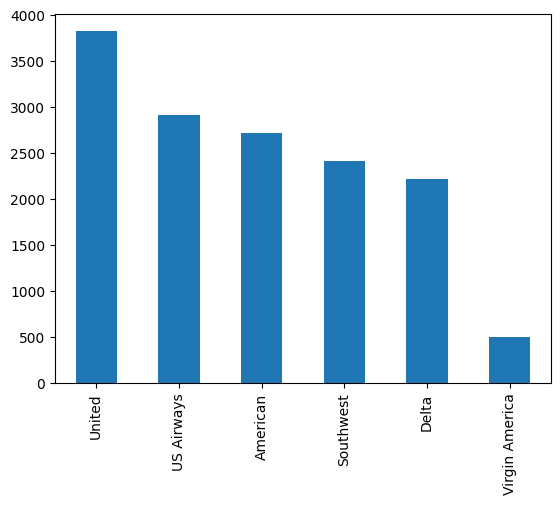

In [ ]:
df.airline.value_counts().plot(kind= "bar")

<Axes: xlabel='airline'>

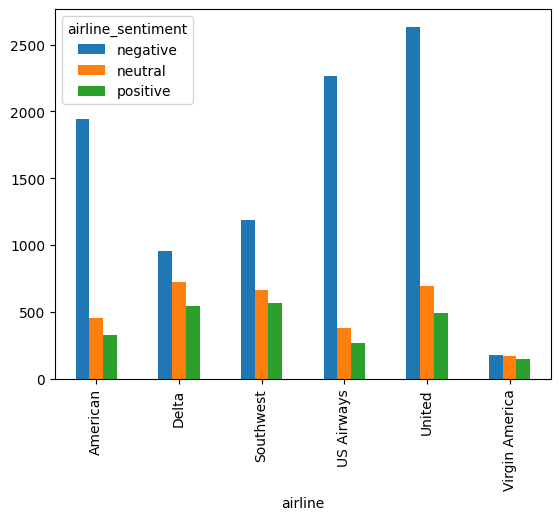

In [ ]:
airline_sentiment =df.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

# Data Cleaning

In [ ]:
df.shape

(14604, 11)

To build a binary SVM classifier for sentiment analysis, you can follow these steps:

Remove neutral sentences: Remove the sentences with neutral sentiment from your dataset. Assuming you have a DataFrame called df with a column named "sentiment" containing the sentiment labels, you can filter out the neutral sentences as follows:

In [ ]:
df = df[df['airline_sentiment'] != 'neutral']


In [ ]:
unique_counts = df['airline_sentiment'].value_counts()
print(unique_counts)


negative    9159
positive    2354
Name: airline_sentiment, dtype: int64


This code snippet filters the DataFrame df and keeps only the rows where the sentiment is not equal to "neutral". As a result, you will have a DataFrame containing only positive and negative sentiments.

Encode sentiment labels: Assign numerical labels to the positive and negative sentiments. You can use the LabelEncoder class from scikit-learn to accomplish this

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode sentiment labels
df.loc[:, 'labels']= label_encoder.fit_transform(df['airline_sentiment'])


In [ ]:
df.shape

(11513, 12)

In [ ]:
df.head(1)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,labels
1,positive,0.3486,NaN,0.0,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1


In [ ]:
unique = df['labels'].value_counts()
print(unique)


0    9159
1    2354
Name: labels, dtype: int64


In [ ]:
df = df.drop(columns="airline_sentiment")

In [ ]:
features= df.drop(columns=['labels'], axis=1).values
labels= df['labels'].values


In [ ]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

### To import the nltk (Natural Language Toolkit) library in Python,

In [ ]:
import nltk
nltk.download('stopwords')
print('The stopwords corpus has been downloaded.')

The stopwords corpus has been downloaded.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer to the tweets and transform the tweets into a sparse matrix
sparse_matrix = vectorizer.fit_transform(processed_features)

# Print the sparse matrix
print(sparse_matrix)


  (0, 963)	1
  (0, 14253)	2
  (0, 20755)	1
  (0, 3721)	1
  (0, 11513)	1
  (0, 20756)	1
  (0, 15767)	1
  (0, 21510)	1
  (0, 20666)	1
  (0, 3327)	1
  (0, 6362)	1
  (0, 19680)	1
  (0, 19310)	1
  (0, 8572)	1
  (0, 19026)	1
  (0, 452)	1
  (0, 22)	1
  (0, 557)	1
  (0, 110)	1
  (0, 225)	1
  (0, 1660)	1
  (0, 50)	1
  (0, 15242)	1
  (0, 19583)	1
  (0, 20525)	1
  :	:
  (11512, 5522)	1
  (11512, 3797)	1
  (11512, 8036)	1
  (11512, 18218)	1
  (11512, 14189)	3
  (11512, 15126)	1
  (11512, 6899)	1
  (11512, 17709)	1
  (11512, 10999)	1
  (11512, 3944)	1
  (11512, 519)	1
  (11512, 14434)	1
  (11512, 5827)	1
  (11512, 7730)	1
  (11512, 3921)	1
  (11512, 13947)	1
  (11512, 11346)	1
  (11512, 13100)	1
  (11512, 3722)	1
  (11512, 3723)	1
  (11512, 15613)	1
  (11512, 2173)	1
  (11512, 6365)	1
  (11512, 18795)	1
  (11512, 18444)	1


In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)


In [ ]:

# Create an instance of SVC (SVM classifier)
svm_classifier = SVC(kernel='linear')

# Train the classifier
svm_classifier.fit(X_train, y_train)


Import the necessary libraries:

Make predictions on the test set using the trained SVM classifier:

In [ ]:

y_pred= svm_classifier.predict(X_test)

Calculate evaluation metrics:

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}, Precision: {precision_score(y_test, y_pred)}, Recall: {recall_score(y_test, y_pred)}, F1-score: {f1_score(y_test, y_pred)}")


Compute the probabilities of the positive class for ROC curve and Precision-Recall curve:

In [ ]:
y_pred_prob = svm_classifier.decision_function(X_test)


Generate the ROC curve and calculate the area under the curve (AUC):

In [ ]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Generate the Precision-Recall curve and calculate the area under the curve (AUC):

In [ ]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


Print the evaluation metrics and areas under the curves:

In [ ]:
print("Accuracy: %.4f" % accuracy)
print("Precision: %.4f" % precision.item())
print("Recall: %.4f" % recall.item())
print("F1-score: %.4f" % f1.item())
print("AUC of ROC curve: %.4f" % roc_auc.item())


To perform a GridSearch cross-validation for various values of hyperparameters C and gamma, you can use the GridSearchCV class from scikit-learn.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 0.01, 0.001],
              'kernel': ['linear', 'rbf', 'poly']}

# Create the SVM classifier
classifier = SVC()  # Change the variable name to 'classifier'

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5)

# Fit the data to perform the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


* ### Try checking if <code>tfidfvectorizer</code> helps you gain lift in model's performance.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score



# Vectorize the text data using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train the SVM classifier

svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
y_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
